# Predicting Henry's law constants

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# for pipeline
from sklearn.pipeline import Pipeline

# for feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# for pre-processing data
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

# for performance evaluation
from sklearn.metrics import mean_squared_error, r2_score

# for building regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

## Loading and splitting data

In [2]:
# import dataset being used
df = pd.read_csv('hcp_features.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4355 entries, 0 to 4354
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Species                          4355 non-null   object 
 1   InChIKey                         4355 non-null   object 
 2   Hcp                              4355 non-null   float64
 3   SMILES                           4355 non-null   object 
 4   Mol                              4355 non-null   object 
 5   exactmw                          4355 non-null   float64
 6   amw                              4355 non-null   float64
 7   lipinskiHBA                      4355 non-null   float64
 8   lipinskiHBD                      4355 non-null   float64
 9   NumRotatableBonds                4355 non-null   float64
 10  NumHBD                           4355 non-null   float64
 11  NumHBA                           4355 non-null   float64
 12  NumHeavyAtoms       

In [4]:
X = df.drop(df.columns[[0, 1, 2, 3, 4, 5]], axis=1)

In [5]:
# creating y matrix from log hcp values
y = [math.log(x, 10) for x in df['Hcp']]

In [6]:
# split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

## Constant variables for each run

In [7]:
# list of regressors that are going to be compared
regressors = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), SVR()]

In [8]:
# creating transformer which will carry out Yeo-Johnson transformation and also standardize the data
pt = PowerTransformer(method='yeo-johnson', standardize=True)

In [9]:
# select top features based on mutual_info_regression
selector = SelectKBest(mutual_info_regression)
selector.fit(X, y)
X.columns[selector.get_support()]

Index(['amw', 'lipinskiHBA', 'NumHBA', 'NumAtoms', 'labuteASA', 'tpsa',
       'CrippenClogP', 'CrippenMR', 'hallKierAlpha', 'kappa1'],
      dtype='object')

## Feature Importance

In [10]:
selector.scores_

array([0.4359592 , 0.49035588, 0.30005963, 0.12925867, 0.28512391,
       0.41141773, 0.25205982, 0.37604017, 0.37354764, 0.07150912,
       0.26815797, 0.20626533, 0.19479047, 0.03549766, 0.02778343,
       0.11706229, 0.06920916, 0.00825072, 0.04649511, 0.02268517,
       0.00411297, 0.04438518, 0.03668138, 0.47029891, 0.66954675,
       0.37421551, 0.39689229, 0.32374919, 0.29720027, 0.13407567,
       0.13330009, 0.11383283, 0.36557465, 0.29277942, 0.20204631,
       0.20228094, 0.20242446, 0.62233671, 0.43722322, 0.27507912,
       0.0896235 , 0.25157231])

In [11]:
# looking at feature scores
scores = pd.DataFrame(data=[selector.feature_names_in_, selector.scores_])

In [12]:
scores

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
1,0.435959,0.490356,0.30006,0.129259,0.285124,0.411418,0.25206,0.37604,0.373548,0.071509,...,0.365575,0.292779,0.202046,0.202281,0.202424,0.622337,0.437223,0.275079,0.089623,0.251572


In [13]:
scores_transposed = scores.transpose()
scores_transposed.rename(columns={0: 'Feature', 1: 'Score'}, inplace=True)

# sort values by descending order of score
scores_transposed = scores_transposed.sort_values('Score', ascending=False)
scores_transposed

,Feature,Score
24,tpsa,0.669547
37,hallKierAlpha,0.622337
1,lipinskiHBA,0.490356
23,labuteASA,0.470299
38,kappa1,0.437223
0,amw,0.435959
5,NumHBA,0.411418
26,CrippenMR,0.396892
7,NumAtoms,0.37604
25,CrippenClogP,0.374216


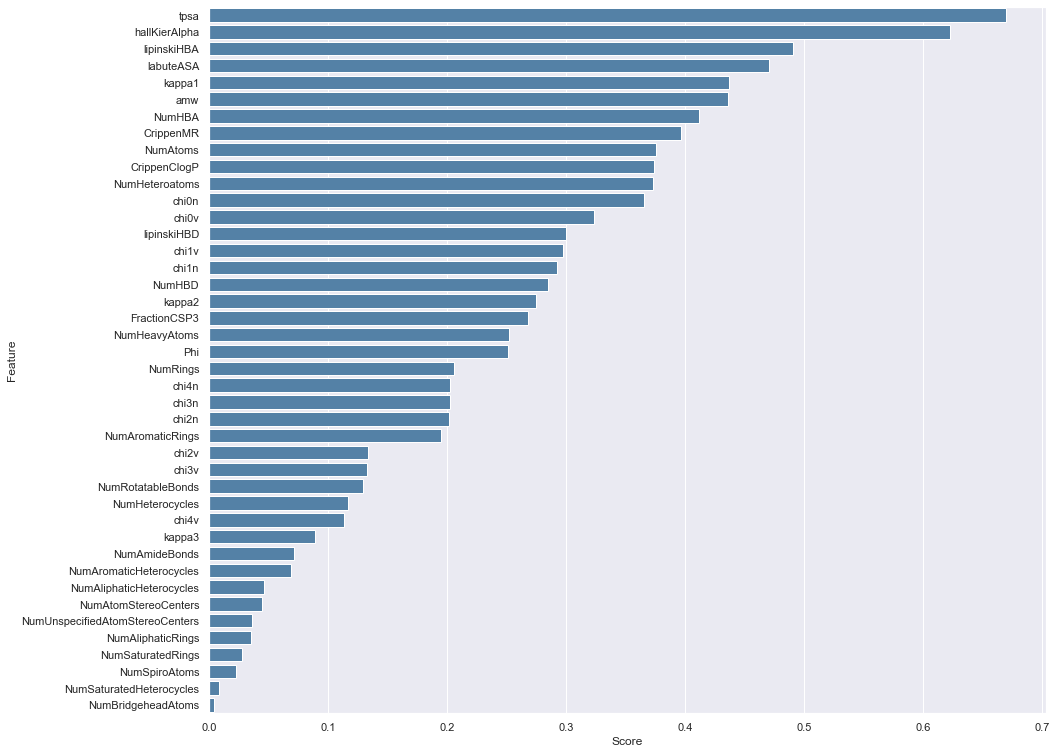

<Figure size 1080x936 with 0 Axes>

In [19]:
sns.barplot(data=scores_transposed, x='Score', y='Feature', color='steelblue')
sns.set(rc = {'figure.figsize':(15,13)})
plt.savefig('hcp_features.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Unprocessed data and untuned models (only thing done is splitting data into training and test sets)

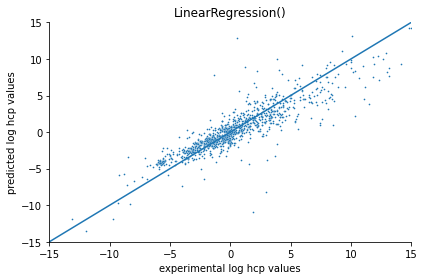

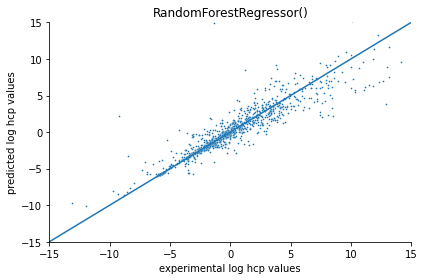

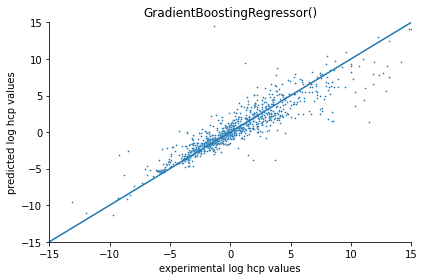

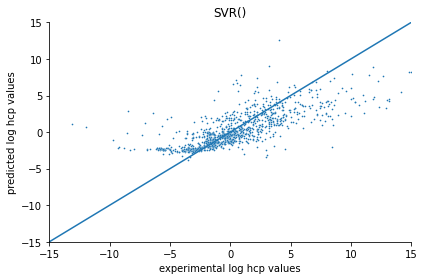

In [16]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
for regressor in regressors:
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # plot scatter graphs of experimental values vs predicted values with x = y line
    sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log hcp values', ylabel='predicted log hcp values')

    # set axis limits to be the same
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-15, 15], y=[-15, 15], alpha=1)

    # aesthetic settings
    sns.despine()
    plt.tight_layout()

    # saving plot
    plt.savefig(f'{regressor}_hcp_test_set.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [11]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.794491,0.808804,1.849135
1,Random Forest Regressor,0.975517,0.829987,1.743696
2,Gradient Boosting Regressor,0.890694,0.815822,1.814883
3,Support Vector Regressor,0.536712,0.516103,2.941754


## Pre-processed data and untuned models

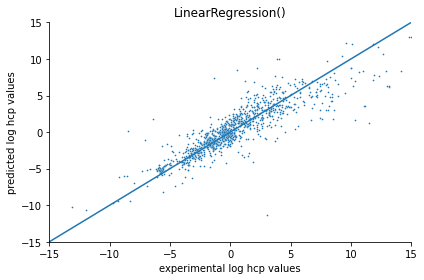

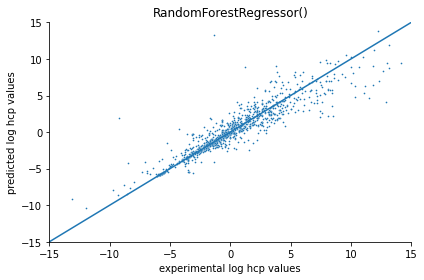

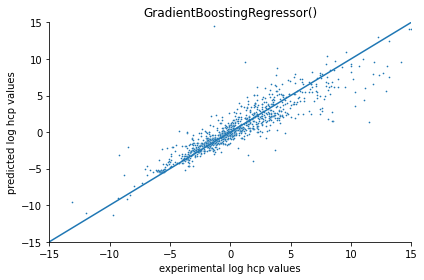

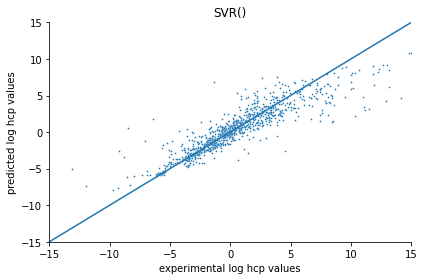

In [15]:
# empty lists to add info into 
models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor']
train_r2 = []
test_r2 = []
rmse = []

# iterate over every regressor
for regressor in regressors:
    
    # pipeline fitting and predicting using regressor
    pipeline = Pipeline(steps = [('transformer', pt), ('regressor', regressor)])
    model = pipeline.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # append scores to lists
    train_r2.append(r2_score(y_train, train_predictions))
    test_r2.append(r2_score(y_test, test_predictions))
    rmse.append(mean_squared_error(y_test, test_predictions, squared=False))
    
    # plot scatter graphs of experimental values vs predicted values with x = y line
    sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title=f'{regressor}', xlabel='experimental log hcp values', ylabel='predicted log hcp values')

    # set axis limits to be the same
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)

    # plot x=y line showing where accurate predictions lie
    sns.lineplot(x=[-15, 15], y=[-15, 15], alpha=1)
    
    # aesthetic settings
    sns.despine()
    plt.tight_layout()

    # saving plot
    plt.savefig(f'{regressor}_hcp_test_set_preprocessed.jpg', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# make dataframe out of lists
scores = pd.DataFrame({'Model': models, 'Train r2': train_r2, 'Test r2': test_r2, 'RMSE': rmse})

In [15]:
scores

,Model,Train r2,Test r2,RMSE
0,Linear Regression,0.780146,0.743607,2.141325
1,Random Forest Regressor,0.975312,0.825818,1.764948
2,Gradient Boosting Regressor,0.890692,0.817013,1.809007
3,Support Vector Regressor,0.763359,0.725020,2.217583


## Preprocessed data and tuned hyperparameters

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
{'regressor__n_estimators': 200, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 23, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 155}
0.986723302857569
0.8186098245289186
1.801094915298939


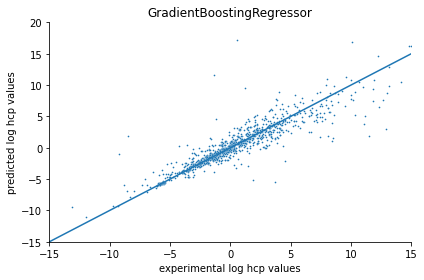

In [10]:
# parameter grid containing hyperparameters to tune
param_grid = {'regressor__max_depth': [int(x) for x in np.linspace(1, 200, 10)],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [int(x) for x in np.linspace(2, 50, 10)],
              'regressor__min_samples_split': [2, 4, 6],
              'regressor__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', GradientBoostingRegressor())])
    
# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1, scoring='neg_root_mean_squared_error')
search.fit(X_train, y_train)
    
print(search.best_params_)

# making predictions with best hyperparameters
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title='GradientBoostingRegressor', xlabel='experimental log hcp values', ylabel='predicted log hcp values')

# set axis limits to be the same
plt.xlim(-15, 15)
plt.ylim(-15, 20)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-15, 15], y=[-15, 15], alpha=1)

# aesthetic settings
sns.despine()
plt.tight_layout()

# saving plot
plt.savefig('gbr_hcp_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
{'regressor__n_estimators': 1000, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'auto', 'regressor__max_depth': 89, 'regressor__bootstrap': True}
0.9620264836849023
0.8326440032723209
1.7300169533934724


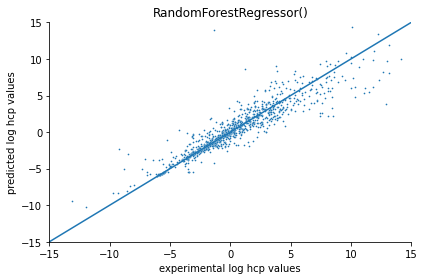

In [9]:
# parameter grid containing hyperparameters to tune
param_grid = {'regressor__bootstrap': [True, False],
              'regressor__max_depth':  [int(x) for x in np.linspace(1, 200, 10)],
              'regressor__max_features': ['auto', 'sqrt'],
              'regressor__min_samples_leaf': [int(x) for x in np.linspace(2, 50, 10)],
              'regressor__min_samples_split': [2, 4, 6],
              'regressor__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', RandomForestRegressor())])
    
# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1, scoring='neg_root_mean_squared_error')
search.fit(X_train, y_train)
    
print(search.best_params_)

# making predictions with best hyperparameters
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))
    
# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title='RandomForestRegressor()', xlabel='experimental log hcp values', ylabel='predicted log hcp values')

# set axis limits to be the same
plt.xlim(-15, 15)
plt.ylim(-15, 15)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-15, 15], y=[-15, 15], alpha=1)

# aesthetic settings
sns.despine()
plt.tight_layout()

# saving plot
plt.savefig('rfr_hcp_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Fitting 30 folds for each of 80 candidates, totalling 2400 fits
{'regressor__C': 3, 'regressor__kernel': 'rbf', 'regressor__tol': 1e-06}
0.8455526470791012
0.7892450071772662
1.9414162287194996


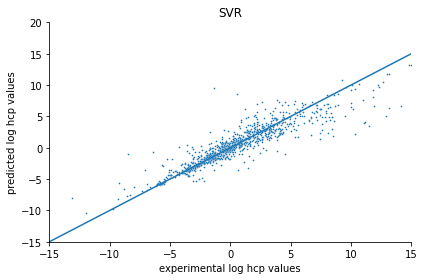

In [18]:
# pipeline fitting and predicting using regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', SVR())])

# parameter grid containing hyperparameters to tune
param_grid = {'regressor__kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 
              'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6], 
              'regressor__C': [1, 1.5, 2, 2.5, 3]}

# grid search cv
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(pipeline, param_grid, cv=cvFold, verbose=2, n_jobs=-1)
search.fit(X_train, y_train)
    
print(search.best_params_)

# making predictions with best hyperparameters
best_model = search.best_estimator_
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)
    
# append scores to lists
print(r2_score(y_train, train_predictions))
print(r2_score(y_test, test_predictions))
print(mean_squared_error(y_test, test_predictions, squared=False))

# plot scatter graphs of experimental values vs predicted values with x = y line
ax = sns.scatterplot(x=y_test, y=test_predictions, s=3).set(title='SVR', xlabel='experimental log hcp values', ylabel='predicted log hcp values')

# set axis limits to be the same
plt.xlim(-15, 15)
plt.ylim(-15, 15)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-15, 15], y=[-15, 15], alpha=1)

# aesthetic settings
sns.despine()
plt.tight_layout()

# saving plot
plt.savefig('svr_hcp_test_set_preprocessed_tuned.jpg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Saving data for melting point predictions

In [10]:
# pipeline fitting and predicting using best regressor
pipeline = Pipeline(steps = [('transformer', pt), ('regressor', RandomForestRegressor(n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=200, bootstrap=True))])
model = pipeline.fit(X_train, y_train)

In [11]:
# adding model predictions to original dataset so predictions can be matched to compound identifiers
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

In [12]:
# create dataframe of predicted and actual values
test_values = pd.DataFrame({'PredictedHcpValues': test_predictions, 'ActualHcpValues': y_test})
train_values = pd.DataFrame({'PredictedHcpValues': train_predictions, 'ActualHcpValues': y_train})
hcp_values = pd.concat([test_values, train_values]).reset_index(drop=True)

In [13]:
hcp_values

,PredictedHcpValues,ActualHcpValues
0,-8.218273,-9.744727
1,2.312973,0.763428
2,-1.912348,-1.236572
3,4.031576,4.079181
4,-0.876933,-5.259637
...,...,...
4350,1.245229,-0.744727
4351,-2.702597,-2.958607
4352,-0.335704,-0.337242
4353,1.816175,2.000000


In [16]:
# adding the corresponding InChIKeys so values can be matched later on
key_train, key_test = train_test_split(df['InChIKey'], random_state=7)
inchikeys = pd.concat([key_test, key_train]).reset_index(drop=True)
hcp_values['InChIKey'] = inchikeys

In [17]:
hcp_values.to_csv('best_hcp_predictions.csv', index=False)